In [176]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import label_binarize
from scipy.signal import savgol_filter
from sklearn.metrics import classification_report


 

X_train = pd.read_csv("data/dataset/xtrain.csv")
y_train = pd.read_csv("data/dataset/ytrain.csv")
X_test = pd.read_csv("data/dataset/xtest.csv")
y_test = pd.read_csv("data/dataset/ytest.csv")
raw = pd.read_csv("data/dataset/raw.csv")
wavelengths = raw.iloc[100:2000,0].to_numpy(dtype=float)
print(wavelengths.shape)
###############################################

#mask_y = ~y_train.iloc[:, 1].isin(["PP", "PTE"])
#mask_X = ~X_train.iloc[:,0].str.contains(r"\((PP|PTE)\)")

#y_train = y_train[mask_y]
#X_train = X_train[mask_X]
#y_test = y_test[mask_y]
#X_test = X_test[mask_X]
#print(X_train)
#print(y_train)

###############################################
print(X_train.shape)
X_train = X_train.iloc[:,100:2000]
X_test = X_test.iloc[:,100:2000]
y_train = y_train.iloc[:, 1]
y_test = y_test.iloc[:, 1]
X_test = X_test.to_numpy()
X_train = X_train.to_numpy()
y_test = y_test.to_numpy()
y_train = y_train.to_numpy()

# encode labels
X_train = savgol_filter(X_train, window_length=50, polyorder=1,deriv=1,axis=1)
X_test = savgol_filter(X_test, window_length=50, polyorder=1,deriv=1,axis=1)
print(X_train.shape)
#le = LabelEncoder()
#y_train = le.fit_transform(y_train)
#y_test  = le.transform(y_test)
#print("Class mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

(1900,)
(839, 2152)
(839, 1900)


This notebook implements a Principal Components Analysis (PCA) preprocessing stage and a Support Vector Machine Classifier (SVM)

The dataset consists of spectra of 4 different plastic with ID's : "PP" ,"PS", "PET" and "PE".

The samples have a significant number of features (reflectances at different wavelengths). We can express this as $X \in \R^D$.

PCA takes the data that exists in this $D$ dimensionalmspace and tries to find the orthogonal axes of $R^D$ where there is more data spread (variance).

It can be applied in 4 steps 

- > Step 1 : Standardize the Data
    - Make each feature have 0 mean and variance 1 
    - $\mu = \{ \mu_1, ... , \mu_D\}$
    - $\sigma = \{ \sigma_1, ... , \sigma_D\}$
    - define the new feature $Z_i = \frac{X_{ij}- \mu_i}{\sigma_i}$
- > Step 2 : Calculate Covariance Matrix

    \begin{equation*}
    \Sigma =
    \begin{bmatrix}
    cov(x^{(1)}, x^{(1)}) & ... & cov(x^{(1)}, x^{(D)}) \\
    .                 & ... & .                 \\
    .                 & ... & .                 \\
    .                 & ... & .                 \\
    cov(x^{(N)}, x^{(1)}) & ... & cov(x^{(N)}, x^{(D)}) \\
    \end{bmatrix}
    \end{equation*}

- > Step 3 : Find the Principal Components
    - Obtain the eigenvectors $X_i$ and respective eigenvalues $ \lambda $ of $ \Sigma $ such that:

    \begin{equation*}
     \Sigma X_i  = \lambda X_i
    \end{equation*}
    - Eigenvalues allow to organize the axis in terms of variance 

- > Step 4 : Pick the Top Directions & Transform Data
     - Pick the eigenvectors where variance in highest 
     - Project the data onto those  eigenvectors




In [ ]:
# Step 1 - Standardize data 
# StandardScaler() description (Sktlearn) : "Standardize features by removing the mean and scaling to unit variance."

#X_standard =  StandardScaler().fit_transform(X_train)

# Step 2 - fit PCA 
# Corresponds to steps 2, 3 and 4 above

# Number of components k 
#k = 0.95
#pca = PCA(n_components=k)
#X_pca = pca.fit_transform(X_standard)

# X_pca is the new data projected onto the subspace of size R^k = R^20
#print(X_pca.shape)
{"PE": 0.8, "PP":1.4}

(839, 699)


{'PE': 0.8, 'PP': 1.4}

The next step is to feed the data onto the model: SVM 

Strong points of SVM's :
- Effective in high dimensional spaces.
- Effective in cases where number of dimensions is greater than the number of samples.
- Ideal for binary class (Not the case here)
By applying PCA we can simplify the decision boundarys of the SVM, whihc are linear. 

SVM strategy for multiclass:

- >  One vs One approach OVO

    -Training Phase:

    We train each class $i$ against each class $j$ and obtain the decision boundary for this classes
    
    Since there are 4 classes this process will be repeated ${4}\choose{2} $ = 6

    What this means is that there are essentially 6 models trained each on a combination of every pair of classes (plastics). So each model functions as a binary classifier.


    Classes are unbalanced so we must weight each class

    -Prediction Phase:

    During prediction, each binary classifier provides a vote for one of the two classes it was trained on.
    The final class prediction for a given sample is determined by a majority vote among all the classifiers.
    This voting mechanism ensures that the class with the most votes is selected as the final output.

---

To take into account class representation use :

\begin{equation}
 w_i = \frac{N}{N_i \, K}
\end{equation}
$N_i$ ->number of times class $i$ appears
$K$ -> number of classes 
$N$ number of samples

In [178]:
class SVM:
    def __init__(self):
        self.model = SVC(C = 1, kernel="sigmoid",
            decision_function_shape="ovo",
            class_weight={"PET": 0.699 , "PP":0.86, "PE":1, "PS": 1.2},
            probability=True
        )
    def fit(self, X_train, y_train):
        self.model.fit(X_train, y_train)
        return self

    def predict(self, X_test):
        return self.model.predict(X_test)

    def predict_proba(self, X_test):
        return self.model.predict_proba(X_test)

In [307]:
 
x = np.random.randint(100)
skf = StratifiedKFold(n_splits=20,shuffle=True,random_state=10)
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=0.9999)),
    ("svm", SVC(C = 1, kernel="linear", # linear is essential provides better CM
        decision_function_shape="ovo",
        class_weight= {"PET": 0.650 , "PP":0.95, "PE": 1.03, "PS": 1.1} 
    ))
])
#{"PET": 0.650 , "PP":0.95, "PE": 1.03, "PS": 0.71}  optimum wheight dict : Avg acc = 0.804
accuracies_validation = []
accuracies_test = []
y_predic = []
y_true_all = []
for fold, (train_idx, test_idx) in enumerate(skf.split(X_train, y_train), 1):
    X_tr, X_te = X_train[train_idx], X_train[test_idx]
    y_tr, y_te = y_train[train_idx], y_train[test_idx]

    pipeline.fit(X_tr, y_tr)
    y_pred = pipeline.predict(X_te)
    acc_validation = accuracy_score(y_te, y_pred)
    accuracies_validation.append(acc_validation)
    y_predic.append(y_pred)
    y_true_all.append(y_te)

    print(f"Fold {fold} accuracy: {acc_validation:.3f}")
print("Mean accuracy:", np.mean(accuracies_validation))
print("Std accuracy:", np.std(accuracies_validation))

y_pred_all = np.concatenate(y_predic)
y_true_all = np.concatenate(y_true_all)
#####################################
######## Test Set evaluation ########
#####################################
pipeline.fit(X_train,y_train)
y_test_pred = pipeline.predict(X_test)
acc_test = accuracy_score(y_test, y_test_pred)
accuracies_test.append(acc_test)

Fold 1 accuracy: 0.952
Fold 2 accuracy: 0.881
Fold 3 accuracy: 0.905
Fold 4 accuracy: 0.952
Fold 5 accuracy: 0.881
Fold 6 accuracy: 0.881
Fold 7 accuracy: 0.905
Fold 8 accuracy: 0.929
Fold 9 accuracy: 0.929
Fold 10 accuracy: 0.952
Fold 11 accuracy: 0.976
Fold 12 accuracy: 0.929
Fold 13 accuracy: 1.000
Fold 14 accuracy: 0.929
Fold 15 accuracy: 0.952
Fold 16 accuracy: 0.976
Fold 17 accuracy: 0.976
Fold 18 accuracy: 0.952
Fold 19 accuracy: 0.881
Fold 20 accuracy: 0.878
Mean accuracy: 0.9308072009291521
Std accuracy: 0.037010724841771765


Accuracy score with train set 0.930870083432658


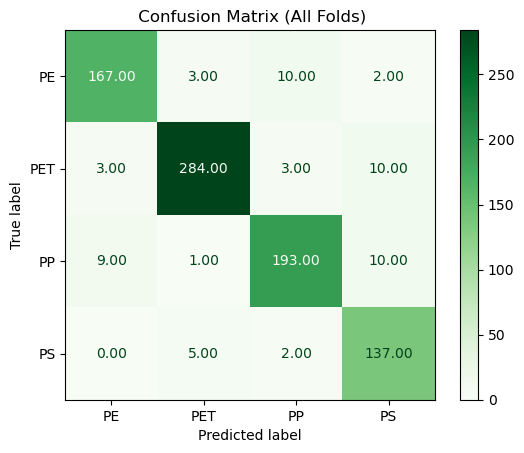

              precision    recall  f1-score   support

          PE       0.93      0.92      0.93       182
         PET       0.97      0.95      0.96       300
          PP       0.93      0.91      0.92       213
          PS       0.86      0.95      0.90       144

    accuracy                           0.93       839
   macro avg       0.92      0.93      0.93       839
weighted avg       0.93      0.93      0.93       839

Accuracy score with test set 0.9619047619047619
Std accuracy: 0.0


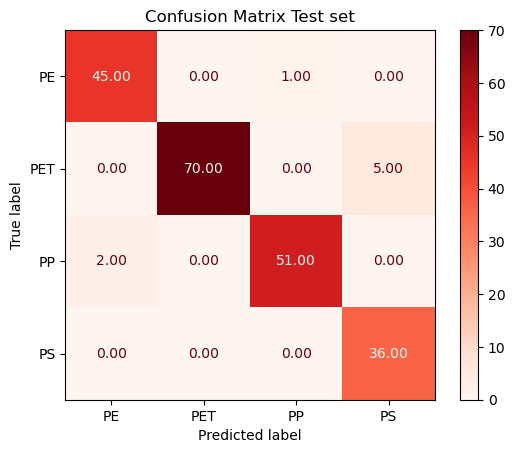

              precision    recall  f1-score   support

          PE       0.96      0.98      0.97        46
         PET       1.00      0.93      0.97        75
          PP       0.98      0.96      0.97        53
          PS       0.88      1.00      0.94        36

    accuracy                           0.96       210
   macro avg       0.95      0.97      0.96       210
weighted avg       0.96      0.96      0.96       210



In [ ]:

Confusion_M_train = confusion_matrix(y_true_all, y_pred_all )
Accuracy_score = accuracy_score(y_true_all, y_pred_all)
print("Accuracy score with train set",Accuracy_score)
class_labels = np.unique(y_true_all)
 
disp = ConfusionMatrixDisplay(
confusion_matrix=Confusion_M_train,display_labels=class_labels)

disp.plot(cmap="Greens", values_format=".2f")
plt.title(" Confusion Matrix (All Folds)")
plt.show()
print(classification_report(y_true_all, y_pred_all))

########################################
########### Test Results ###############
########################################
Confusion_M_train = confusion_matrix(y_test, y_test_pred )
Accuracy_score_test = accuracy_score(y_test, y_test_pred)
print("Accuracy score with test set",Accuracy_score_test)
class_labels_test = np.unique(y_test)
disp = ConfusionMatrixDisplay(
confusion_matrix=Confusion_M_train,display_labels=class_labels_test)

disp.plot(cmap="Reds", values_format=".2f")
plt.title("Confusion Matrix Test set")
plt.show()
print(classification_report(y_test, y_test_pred))

Analysis 

This notebook uses a support vector machine (SVM) classification model to classify a dataset of 4 plastics containing four different classses ( PET, PP , PS, PE).
 

The output of the model is evaluated by a accuracy level, precision level and recall level. 

Accuracy measures the amount of correct predictions of the model from the total amount of predictions.
- Accuracy is measured as:

\begin{equation}
\text{Accuracy} = \frac{\text{True Positives}}{\text{Total Prediction}}
\end{equation}

Precision allows to quantify how often the models predictions are correct:
- Its a class specific measure.

- Precision is measured as :
\begin{equation}
\text{Precision} = \frac{\text{True Positives}}{\text{True Positives + False Positives}}
\end{equation}

Recall allows to quantify the proportion of class members that the models predicted correctly.
- Its a class specific measure.
- Recall is  measured as:
\begin{equation}
 \text{Recall} = \frac{\text{True Positives}}{\text{True Positives + False Negatives}}
\end{equation}

Accuracy is an overall measures, the higher the better. But recall and precision must be analysed together. for example :

- If recall is high for a certain class, A. Then it means it predicts a significant proportion of the samples of that class. 
 
 But if at the same time precision is low, it means that there are many false positives for class A, suggesting that the model as a high bias  towards predicting that class.

 In this situation the correct procedure is, for example, to penalize class A.

- If precision is high for class A, it suggests the model is very confident when predicting for that given class. But is recall is low, then the model doesnt predict a lot

of samples from class A. This suggests that it can't generalize well for that class.



The data samples and test samples were first applied to savgol filter. The intention of this is to remove noise and smooth the spectrums of the samples. Also the "deriv" parameter is set to 1, this had a significant impact on the accuracy (from 0.78 to 0.94), This could be explained by the fact that the derivative takes into account only local information, namely the rate of change of the spectrum, then by applying this operation the resulting spectrum highlights parts of the spectrum where there is variation. 
The "window length" parameter allows to smooth the spectral components within a window of size "window length". Thid parameter also contributes to better accuracy results.

Removing the first $100$ and last $150$ features of the each samples, corresponding to a spectrum going from $450 nm$ up to $2350 nm$ also contributed to better accuracy results overall. This procedure was motivated by the fact that the spectrums of all samples have significant noise around this wavelengths, therefore not containing usefull information to classify the samples.

After preprocessing the data was processed by a PCA stage. The main hyperparameter to tune is the number of principal components in which to project the data. This number provides good 
results when its around 50 - 80 corresponding to a variance of $0.999 \% $. This stage is also essential since removing it completely removes the accuracy of the model, (accuracy = 0.26 without PCA). 
Certainly each feature (wavelength) doesn't contain, on its own, that much information, and since there are more features than samples then it is plausible that
by compacting the dimensional space of the samples it would aid the classification process of the SVM.

The classificator was a SVM, applied toa  multiclass problem. The strategie was one versus one allowing for direct comparison between different pairs of class

The classes are unbalaced and have the following populations:

- PET -300

- PP - 213

- PE - 182

- PS - 144

This class imbalance is taken into account in the SVM model by adding a dictionary with the class weights. This weights are a hyperparameter and were manually optimized.
A good weight distribution was found to be:

 - PET : 0.650 
 - PP : 0.95
 - PE : 1.03 
 - PS : 1.1 

Since PET is the most represented class it makes sense it would be the most penalized (smallest weight). PP being the second most represented is slightly penalized. 
PE being the third most represented as a slightly favorability. PS the least represented is the most favored.

Another parameter in the kernel which is the type of decision boundary. It was set to linear since it provided by far the best results. Suggesting the data is linearly seperable 

The results for the validation set, for various k folds parameter, show a consistent accuracy around 0.93, global precision of 0.92 and global recall of 0.93. 
The standard deviation of accuracy is around 0.03. This suggests the classification is process is confident and close to the true value. 
Looking at the confusion matrix it can be seen that the PET plastic isoften times missclassified PS. This could be due to the penalty for class PET, despite varying this parameter it was
not possible to remove this bias in the validation set. 
This observation suggests that either better hyperparameter tuning is necessary or that the classes PS and PET overlap slightly which could be a limitation of the linear classifier.

The test set showed results similar with the validation set, although with higher accuracy (0.96), higher precision (0.95) and higher recall (0.97). 
The better results could be due to a more favorable test set. This is a possible explanation since the number of plastic samples was already small before train and test split.
Also the classification bias of PS when the true class is PET is observable, indicating that maybe the decision boundary of PET and PS due in fact overlap slightly explaining this consistent behaviour.


Its important to note that each class as plastic sample in different conditions, therefore this clas




Below is a plot of the data smaples at different levels of preprocessing

(839, 66)
(839, 1900)
(210, 1900)


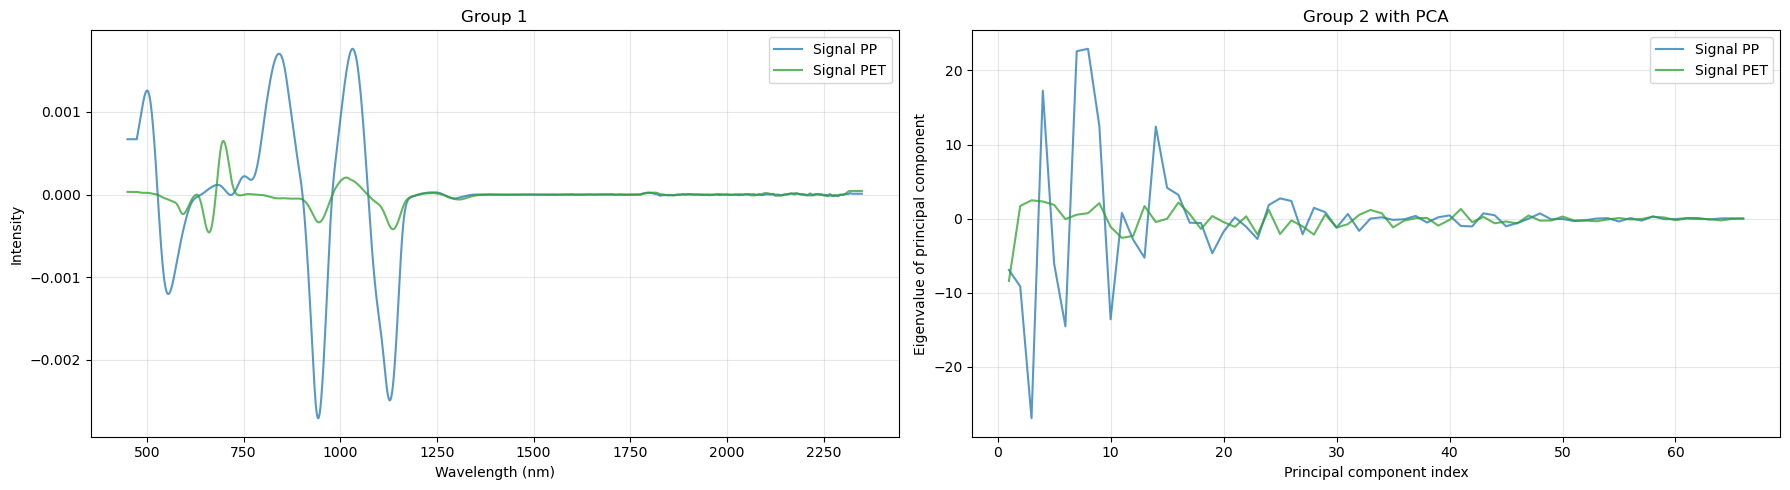

In [ ]:


X_standard =  StandardScaler().fit_transform(X_train)
k = 0.9999 
pca = PCA(n_components=k)
X_pca = pca.fit_transform(X_standard)
x_axis_pca = np.linspace(1, X_pca.shape[1],X_pca.shape[1])
print(X_pca.shape)
 
fig, (plt1, plt2) = plt.subplots(1,2,figsize=(18, 5))
print(X_train.shape)
print(X_test.shape)
x = np.random.randint(100)
# Colormap for other signals
colors = plt.cm.tab10(np.linspace(0, 1, 5))

# Plot first group - only savgol filter
for i in range(2):
    plt1.plot(wavelengths, X_train[i+x, :], label=f'Signal {y_train[i+x]}', 
              color=colors[i], linewidth=1.5, alpha=0.75)

plt1.set_title('Group 1- only savgol filter  ')
plt1.set_xlabel('Wavelength (nm)')
plt1.set_ylabel('Intensity')
plt1.grid(True, alpha=0.3)
plt1.legend()
# Plot second group with PCA group
for i in range(2):
    plt2.plot(x_axis_pca, X_pca[i+x, :], label=f'Signal {y_train[i+x]}', 
              color=colors[i], linewidth=1.5, alpha=0.75)

plt2.set_title('Group 2 with PCA')
plt2.set_xlabel('Principal component index')
plt2.set_ylabel('Eigenvalue of principal component')
plt2.grid(True, alpha=0.3)
plt2.legend()


plt.tight_layout()
plt.show()
